Notebook này dùng để đánh giá mô hình LBPH đã train và lưu dưới dạng lbph_model.xml.

**Quy trình:**

1. Load dữ liệu validation & test (ảnh đã crop mặt)

2. Load LBPH model từ checkpoint

3. Phân tích confidence (raw)

4. Tìm threshold tối ưu trên validation

5. Đánh giá model trên test

In [2]:
import cv2
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
!pip install -q opencv-contrib-python


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


IMPORTS & CONFIG

In [9]:
DATASET_DIR = "/content/drive/MyDrive/LBPH_DATASET"
VAL_DIR  = os.path.join(DATASET_DIR, "val")
TEST_DIR = os.path.join(DATASET_DIR, "test")

MODEL_PATH = "/content/drive/MyDrive/LBPH_MODEL/lbph_model.xml"

LOAD DATA (ẢNH ĐÃ CROP MẶT)

In [6]:
def load_lbph_data(root_dir):
    faces = []
    labels = []

    for label in sorted(os.listdir(root_dir)):
        class_dir = os.path.join(root_dir, label)
        if not os.path.isdir(class_dir):
            continue

        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue

            faces.append(img)
            labels.append(int(label))

    return faces, labels


In [10]:
val_faces, val_labels = load_lbph_data(VAL_DIR)
test_faces, test_labels = load_lbph_data(TEST_DIR)

print("Val images:", len(val_faces))
print("Test images:", len(test_faces))


Val images: 149
Test images: 149


In [11]:
import os

print("MODEL_PATH:", MODEL_PATH)
print("Exists:", os.path.exists(MODEL_PATH))
print("Is file:", os.path.isfile(MODEL_PATH))


MODEL_PATH: /content/drive/MyDrive/LBPH_MODEL/lbph_model.xml
Exists: True
Is file: True


LOAD LBPH MODEL (CHECKPOINT)

In [12]:
model = cv2.face.LBPHFaceRecognizer_create()
model.read(MODEL_PATH)

print("✅ LBPH model loaded")


✅ LBPH model loaded


PHÂN TÍCH CONFIDENCE (RAW)

In [13]:
confidences = []
correct_flags = []

for img, true_label in tqdm(zip(val_faces, val_labels), total=len(val_faces)):
    pred, conf = model.predict(img)
    confidences.append(conf)
    correct_flags.append(pred == true_label)


100%|██████████| 149/149 [00:02<00:00, 62.96it/s]


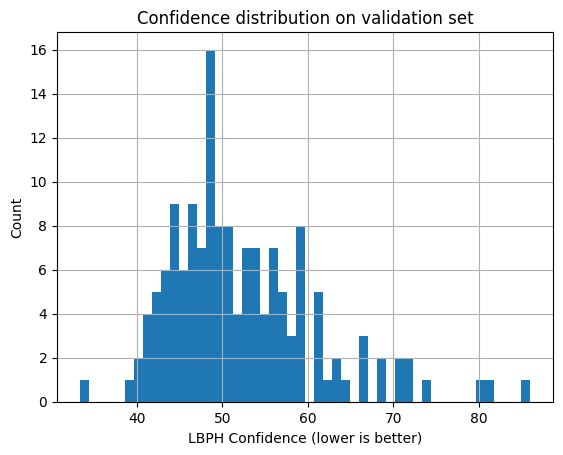

In [14]:
plt.hist(confidences, bins=50)
plt.xlabel("LBPH Confidence (lower is better)")
plt.ylabel("Count")
plt.title("Confidence distribution on validation set")
plt.grid()
plt.show()


TÌM THRESHOLD TỐI ƯU (VALIDATION)

In [15]:
def eval_lbph(model, faces, labels, threshold):
    correct = 0
    used = 0

    for img, true_label in zip(faces, labels):
        pred, conf = model.predict(img)
        if conf < threshold:
            used += 1
            if pred == true_label:
                correct += 1

    acc = correct / used if used > 0 else 0
    coverage = used / len(faces)
    return acc, coverage, used


In [16]:
thresholds = range(40, 121, 5)

results = []

for thr in thresholds:
    acc, cov, used = eval_lbph(model, val_faces, val_labels, thr)
    results.append((thr, acc, cov))
    print(f"thr={thr:3d} | acc={acc:.3f} | cov={cov:.3f} | used={used}")


thr= 40 | acc=1.000 | cov=0.013 | used=2
thr= 45 | acc=0.267 | cov=0.201 | used=30
thr= 50 | acc=0.257 | cov=0.497 | used=74
thr= 55 | acc=0.248 | cov=0.678 | used=101
thr= 60 | acc=0.213 | cov=0.852 | used=127
thr= 65 | acc=0.206 | cov=0.913 | used=136
thr= 70 | acc=0.199 | cov=0.946 | used=141
thr= 75 | acc=0.192 | cov=0.980 | used=146
thr= 80 | acc=0.192 | cov=0.980 | used=146
thr= 85 | acc=0.189 | cov=0.993 | used=148
thr= 90 | acc=0.188 | cov=1.000 | used=149
thr= 95 | acc=0.188 | cov=1.000 | used=149
thr=100 | acc=0.188 | cov=1.000 | used=149
thr=105 | acc=0.188 | cov=1.000 | used=149
thr=110 | acc=0.188 | cov=1.000 | used=149
thr=115 | acc=0.188 | cov=1.000 | used=149
thr=120 | acc=0.188 | cov=1.000 | used=149


In [17]:
MIN_COVERAGE = 0.3

best_thr = None
best_score = -1

for thr, acc, cov in results:
    if cov >= MIN_COVERAGE:
        score = acc * cov
        if score > best_score:
            best_score = score
            best_thr = thr

print("✅ Selected threshold:", best_thr)


✅ Selected threshold: 65


ĐÁNH GIÁ FINAL TRÊN TEST

In [18]:
test_acc, test_cov, test_used = eval_lbph(
    model, test_faces, test_labels, best_thr
)

print("🎯 TEST accuracy:", test_acc)
print("📊 Coverage:", test_cov)
print("📦 Used:", test_used, "/", len(test_faces))


🎯 TEST accuracy: 0.13432835820895522
📊 Coverage: 0.8993288590604027
📦 Used: 134 / 149


SUMMARY

In [19]:
print(f"""
LBPH Evaluation Summary
-----------------------
Threshold       : {best_thr}
Test Accuracy   : {test_acc:.3f}
Test Coverage   : {test_cov:.3f}

Observation:
LBPH shows strong conservativeness on unconstrained face images.
Accuracy drops significantly when coverage increases, highlighting
the limitation of traditional texture-based methods compared to
deep embedding models such as ArcFace and FaceNet.
""")



LBPH Evaluation Summary
-----------------------
Threshold       : 65
Test Accuracy   : 0.134
Test Coverage   : 0.899

Observation:
LBPH shows strong conservativeness on unconstrained face images.
Accuracy drops significantly when coverage increases, highlighting
the limitation of traditional texture-based methods compared to
deep embedding models such as ArcFace and FaceNet.

